In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPTextModel, CLIPTokenizer, CLIPImageProcessor
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, AutoencoderKL, EulerDiscreteScheduler, PNDMScheduler
import torch.nn as nn
from PIL import Image
from torchvision import transforms
from torchinfo import summary
from accelerate import Accelerator
from _utils import *

TRANS_MODEL = "openai/clip-vit-large-patch14"
DIFF_MODEL = "CompVis/stable-diffusion-v1-4"
dtype=torch.float16
image_path = "img.png"

In [3]:
# fern = np.load('fern.npy', allow_pickle=True)
# lego = np.load('lego.npy', allow_pickle=True)
# dataset = NeRFDataset([fern, lego])
# dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [4]:
class CustomEncoder(nn.Module):
    def __init__(self, original_encoder):
        super().__init__()
        self.original_encoder = original_encoder
        self.custom_layer = nn.Conv2d(in_channels=original_encoder.conv_out.out_channels, 
                                      out_channels=original_encoder.conv_out.out_channels, 
                                      kernel_size=3, padding=1)

    def forward(self, x):
        x = self.original_encoder(x)
        # x = self.custom_layer(x)
        return x

class CustomDecoder(nn.Module):
    def __init__(self, original_decoder):
        super().__init__()
        self.original_decoder = original_decoder
        self.custom_layer = nn.Conv2d(in_channels=original_decoder.conv_in.in_channels, 
                                      out_channels=original_decoder.conv_in.in_channels, 
                                      kernel_size=3, padding=1)

    def forward(self, x):
        x = self.original_decoder(x)
        # x = self.custom_layer(x)
        return x


In [5]:
text_encoder = CLIPTextModel.from_pretrained(TRANS_MODEL)
tokenizer = CLIPTokenizer.from_pretrained(TRANS_MODEL)
feature_extractor = CLIPImageProcessor.from_pretrained(TRANS_MODEL)


# d = {
#     "beta_end": 0.012,
#     "beta_schedule": "scaled_linear",
#     "beta_start": 0.00085,
#     "num_train_timesteps": 1000,
#     "set_alpha_to_one": False,
#     "skip_prk_steps": True,
#     "steps_offset": 1,
#     "trained_betas": None,
# }
# scheduler = EulerDiscreteScheduler.from_pretrained(DIFF_MODEL, subfolder="scheduler")
scheduler = PNDMScheduler.from_pretrained(DIFF_MODEL, subfolder="scheduler", torch_dtype=dtype)
unet = UNet2DConditionModel.from_pretrained(DIFF_MODEL, subfolder="unet", torch_dtype=dtype)

vae = AutoencoderKL.from_pretrained(DIFF_MODEL, subfolder="vae", torch_dtype=dtype)
vae.encoder = CustomEncoder(vae.encoder)
vae.decoder = CustomDecoder(vae.decoder)
# vae.apply(initialize_weights)

# Stable Diffusion Pipeline 초기화
# pipe = StableDiffusionPipeline(
#     vae=vae,
#     text_encoder=text_encoder,
#     tokenizer=tokenizer,
#     unet=unet,
#     scheduler=scheduler,
#     safety_checker=None,
#     feature_extractor=feature_extractor, 
#     image_encoder=None,
#     requires_safety_checker=False, 
# )
pipe = StableDiffusionPipeline.from_pretrained(DIFF_MODEL, torch_dtype=dtype)
# pipe.vae = vae
# pipe.unet = unet
# pipe.scheduler = scheduler

pipe = pipe.to("cuda")
# 
# for param in pipe.unet.parameters():
#     param.requires_grad = False
# 
# for param in pipe.text_encoder.parameters():
#     param.requires_grad = False

C:\Users\dinle\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [6]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(pipe.vae.parameters(), lr=1e-4)
accelerator = Accelerator()

In [8]:
prompt = "a Cat"
H = 512
W = H
dataset = SingleImageDataset(tokenizer, image_path, prompt, H)
dataloader = DataLoader(dataset, batch_size=1)
img_real = make_image(image_path, dtype, H)

In [9]:
model, optimizer, training_dataloader, scheduler = accelerator.prepare(
     pipe, optimizer, dataloader, scheduler
)

  0%|          | 0/50 [00:00<?, ?it/s]

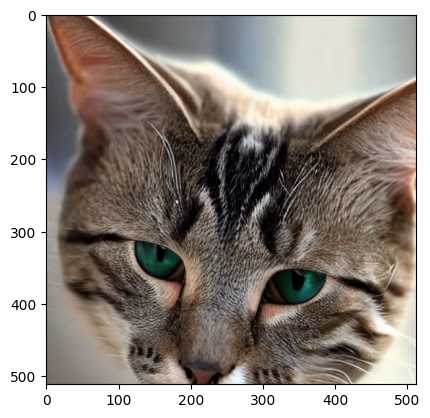

In [8]:
with torch.no_grad():
    result = pipe(prompt, height =H, width=W, output_type='pt')
    img_gen = result.images
    plt_img(img_gen[0])
    

Recon


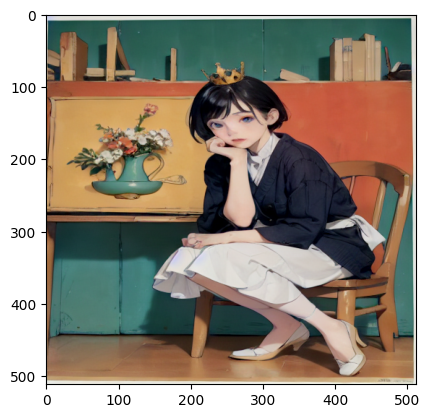

Epoch [1/10], Loss: 0.0015630722045898438
Recon


C:\Users\dinle\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


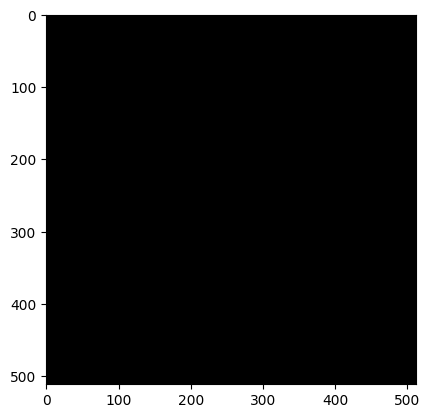

Epoch [2/10], Loss: nan
Recon


KeyboardInterrupt: 

In [10]:
with torch.no_grad():
    latents_org = pipe.vae.encode(img_real).latent_dist.sample() 
    
init = True

num_epochs = 10
for epoch in range(num_epochs):
    for batch in dataloader:
        optimizer.zero_grad()
        prompt = batch["prompt"]

        # VAE를 사용하여 이미지 인코딩 및 디코딩
        # with torch.enable_grad():  # VAE에서만 그래디언트를 허용
        #     # VAE를 사용하여 이미지 인코딩 및 디코딩
        if not init:
            vae.apply(initialize_weights)
            init = True
        
        latents = pipe.vae.encode(img_real).latent_dist.sample()

        img_rec = pipe.vae.decode(latents).sample
        print('Recon')
        plt_img(img_rec[0])
        
        # result = pipe(prompt, height =H, width=W, output_type='pt')
        # img_gen = result.images
        # latents_gen = result.latents[0]
        
        # print('Gen')
        # plt_img(img_gen[0])
        
        # 손실 계산 및 역전파
        loss_enc = criterion(latents, latents_org)
        loss_dec = criterion(img_rec, img_real)
        # loss_pipe = criterion(img_gen, img_real)
        
        loss = loss_enc + loss_dec 
        accelerator.backward(loss)
        optimizer.step()
        
        del img_rec
        # del img_gen
        del latents
        # del latents_gen
        torch.cuda.empty_cache()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

In [ ]:
with torch.no_grad():
    img_rec = vae(img_real)
    plt_img(img_rec[0][0])

In [ ]:
img2 = make_image('img2.png',H)
with torch.no_grad():
    img_rec2 = vae(img2)
    plt_img(img_rec2[0][0])